<img src="cropped-SummerWorkshop_Header.png">  

<h1 align="center"> Workshop 1: Tutorial on behavioral states</h1> 
<h2 align="center"> Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center"> Thursday, June 14th, 2023</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to the concepts of behavioral state...
</div>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

pd.set_option('display.max_columns', None)

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> First, we will introduce the Visual Behavior dataset (<a href="https://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels">link to data</a>). This dataset consists of recordings of neural activity measured using 6 Neuropixels probes from mice that have learned to perform an image change detection task.  Recordings are made simultaneously from neurons distributed across layers in the visual cortex ( VISp, VISl, VISal, VISrl, VISam, and VISpm), neurons in the hippocampus (CA1/3, DG), and neurons in the visual thalamus (LP and LGd).
    
<p> In this in this go/no-go task task, mice learn to report changes in stimulus identity by licking a spout to earn a water reward. In short, mice are shown a continuous series of visual images that are briefly presented and they earn water rewards by correctly reporting when the identity of the image changes (diagrammed below). 
     
</div>

<img src="download.png">  

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
The Neuropixels Visual Behavior dataset is accessed with the Python module `BehaviorEcephysSession`.  We begin by importing this module.
We also provide the path to the NWBs that store the session information from all mice.
    
</div>

In [3]:
from allensdk.brain_observatory.ecephys.behavior_ecephys_session import BehaviorEcephysSession

from utils import get_session, get_session_table, get_units_table, get_probes_table, get_channels_table

path_to_nwbs = '/root/capsule/data/visual_behavior_neuropixels/visual-behavior-neuropixels-0.4.0/behavior_ecephys_sessions/'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let us look at a session file and the metadata recorded related to a single trial.
</div>

In [4]:
example_sessions = [1139846596, 1124507277, 1069461581, ]

session_id = example_sessions[0]
session = get_session(session_id)

trial_metadata = session.trials

display(trial_metadata.head()) # to do: add precomputed response time? 

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
0,27.66076,28.61154,im104_r,im104_r,False,NaN,False,False,[28.27695],NaN,NaN,0.0,False,False,False,False,True,False,NaN,0.95078
1,29.16146,30.88003,im104_r,im104_r,False,NaN,False,False,[30.56264],NaN,NaN,0.0,False,False,False,False,True,False,NaN,1.71857
2,31.41341,33.53196,im104_r,im104_r,False,NaN,False,False,"[32.7479, 32.94767, 33.21476]",NaN,NaN,0.0,False,False,False,False,True,False,NaN,2.11855
3,33.66560,36.08416,im104_r,im104_r,False,NaN,False,False,[35.76732],NaN,NaN,0.0,False,False,False,False,True,False,NaN,2.41856
4,36.66823,38.33614,im104_r,im104_r,False,NaN,False,False,[38.01908],NaN,NaN,0.0,False,False,False,False,True,False,NaN,1.66791


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
How well does the mouse recognize a change in the image sequences? We can quantify their performance by evaluating the percentage of 'go' trials during which the mouse licked the spout.      
</div>

In [5]:
num_go_trials = len(np.where(trial_metadata.go)[0])
num_go_hit_trials = len(np.where(trial_metadata.hit[trial_metadata.go])[0])
print('Proportion of trials correctly performed: ' + str(np.round(num_go_hit_trials/num_go_trials, 2)))

Proportion of trials correctly performed: 0.46


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  We have listed three example sessions here, access the metadata from each of the sessions. Print the proportion of 'go' trials that the mouse performed correctly and evaluate their mean performance.
</div>

In [6]:
# Blank coding cell to work out the task  


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Looks like the mice fail in about 20-30% of the trials! We can look at their licking patterns to get a sense of this number.
</div>

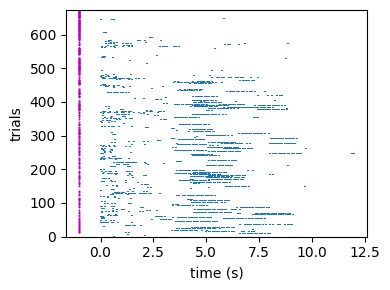

In [7]:
# Lick raster
lick_times = trial_metadata.lick_times.values - trial_metadata.start_time.values

fig, ax = plt.subplots(figsize = (4, 3))
ax.eventplot(lick_times, linelength = 1.5);
go_trials =  trial_metadata[trial_metadata.go].index
ax.plot(-1*np.ones(len(go_trials)), go_trials, marker = '*', ls = 'none', color = 'm', ms = 0.8)
ax.set_ylim(-0.5, len(lick_times))
ax.set_ylabel('trials')
ax.set_xlabel('time (s)')
plt.tight_layout()

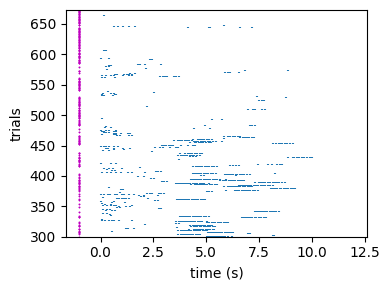

In [8]:
# Lick raster
lick_times = trial_metadata.lick_times.values - trial_metadata.start_time.values

fig, ax = plt.subplots(figsize = (4, 3))
ax.eventplot(lick_times, linelength = 1);
go_trials =  trial_metadata[trial_metadata.go].index
ax.plot(-1*np.ones(len(go_trials)), go_trials, marker = '*', ls = 'none', color = 'm', ms = 0.8)
ax.set_ylim(300, len(lick_times))
ax.set_ylabel('trials')
ax.set_xlabel('time (s)')
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b> Plot lick rasters for the other example mice. What do their lick trends look like?
</div>

In [9]:
# Blank coding cell to work out the task  

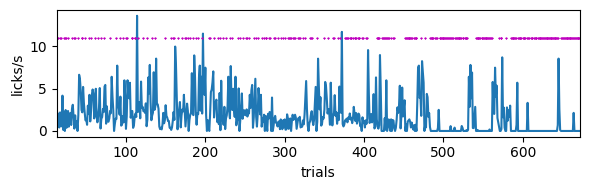

In [10]:
# lick rate 

fig, ax = plt.subplots(figsize = (6, 2))
lick_rate = trial_metadata.apply(lambda row : len(row['lick_times'])/(row['stop_time'] - row['start_time']), axis = 1)
ax.plot(lick_rate)
ax.plot(go_trials,11*np.ones(len(go_trials)), marker = '*', ls = 'none', color = 'm', ms = 1 ) 

ax.set_ylabel('licks/s')
ax.set_xlabel('trials')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

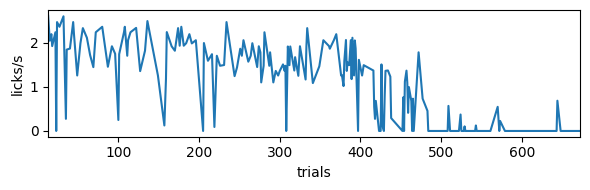

In [11]:
# lick rate during go trials

fig, ax = plt.subplots(figsize = (6, 2))
lick_rate = trial_metadata[trial_metadata.go].apply(lambda row : len(row['lick_times'])/(row['stop_time'] - row['start_time']), axis = 1)
ax.plot(go_trials, lick_rate)

ax.set_ylabel('licks/s')
ax.set_xlabel('trials')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Could the mouse be disenaging from the task as they reach the end of the session? Although, lick rate does indicate this, disengaged mice could also perform persistent licking regardless of the task. Therefore, to test our hypothesis, we quantify two metrics:
<p> 1. hit rate: Hit rate is the probabilitY that a mouse would correctly perform a lick during 'go' trials. This is evaluated as the fraction over 10 go-trials in which the mouse licked correctly to the changed image. 
    
<p> 2. d prime: d prime is a measure of the relative difference in response probabilities across the two trial types, hits and false alarms. It is defined as: 
                                                                d' = Z(h) - Z(f)

    
</div>

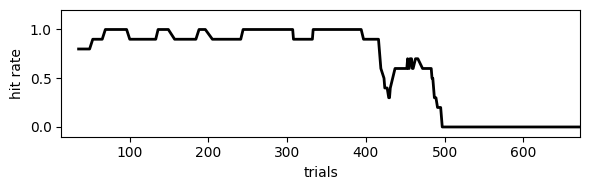

In [12]:
# compute hit rate with 10 trial rolling window
hit_rate = trial_metadata.hit[trial_metadata.go].rolling(10).mean()

# compute d prime
Z = norm.ppf
num_catch_trials = len(np.where(trial_metadata.catch)[0])
num_catch_hit_trials = len(np.where(trial_metadata.hit[trial_metadata.catch])[0])

hr = num_go_hit_trials/num_go_trials
fa = num_catch_hit_trials/num_catch_trials # something wrong, fa = 0 ?! 

d_prime = Z(hr) - Z(fa)

fig,ax = plt.subplots(figsize = (6, 2)) 
ax.plot(go_trials, hit_rate, color = 'k', lw = 2)
# ax.text(500, 1, r"$d^{'}$ = " + str(np.round(d_prime, 2)))
ax.set_xlim(go_trials[0], go_trials[-1])
ax.set_ylim(-0.1, 1.2)
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')

plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Let us set an approximate threshold on hit rate to define engaged and disengaged states. 
</div>

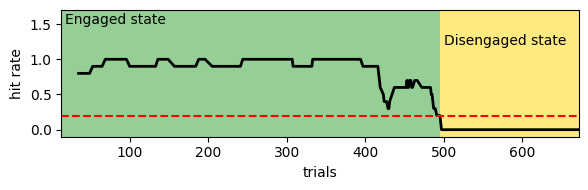

In [13]:
engagement_threshold = 0.2

fig,ax = plt.subplots(figsize = (6, 2)) 
ax.plot(go_trials, hit_rate, color = 'k', lw = 2)
ax.plot(go_trials, 0.2*np.ones(num_go_trials), color = 'r', ls = '--')

states = hit_rate < engagement_threshold
switch_trials = np.where(np.diff(states.values))[0]
switch_trials = np.concatenate(([0], switch_trials, [num_go_trials-1]))
for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.text(go_trials[trial] + 5, 1.5, 'Engaged state', color = 'k', size = 10)
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
    else:
        ax.text(go_trials[trial] + 5, 1.2, 'Disengaged state', color = 'k', size = 10)
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5)
ax.set_ylim(-0.1, 1.7)
ax.set_xlim(go_trials[0], go_trials[-1])
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.3:</b> Evaluate the correlation between hit rate and licking during 'go' trials. 
</div>

In [14]:
# Blank coding cell to work out the task  



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Does the mouse change its behavior as it disengages? Throughout each session, mouse running speed and pupil area were also recorded, as well as earned rewards. 
</div>

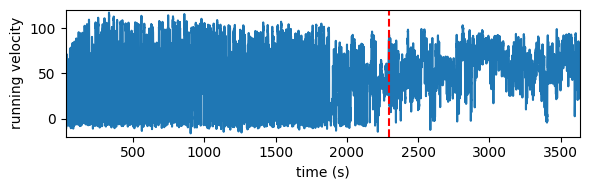

In [15]:
# running speed

running_time = session.running_speed.timestamps
running_speed = session.running_speed.speed
stop_time = trial_metadata.stop_time.max()
start_time = trial_metadata.start_time.min()

fig,ax = plt.subplots(figsize = (6, 2)) 
plt.plot(running_time, running_speed)
ax.set_xlim(start_time, stop_time)

time_at_switch = trial_metadata.iloc[go_trials[np.where(np.diff(states.values))[0]]].start_time.values
        
for i in range(len(time_at_switch)):
    plt.plot(time_at_switch[i]*np.ones(5), np.linspace(-20, 120, 5), color = 'r' , ls = '--')
ax.set_ylim(-20, 120)
ax.set_xlabel('time (s)')
ax.set_ylabel('running velocity')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> This plot is noisy and it is difficult to point out trial-wise changes in the running speed. We can smooth this plot out and analyse mean running speed in each trial to find any correlates of state transitions in the go trials.  
</div>

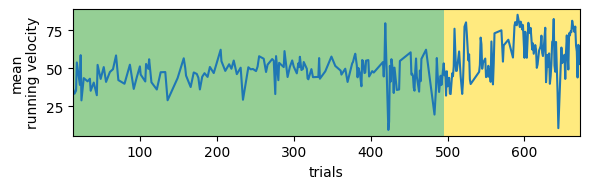

In [16]:
# mean running speed in each trial

trial_start = trial_metadata.start_time[np.where(trial_metadata.go)[0]]
trial_stop = trial_metadata.stop_time[np.where(trial_metadata.go)[0]]

mean_speed = [np.nanmean(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

fig,ax = plt.subplots(figsize = (6, 2))
plt.plot(go_trials, mean_speed)

for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5)

ax.set_xlabel('trials')
ax.set_ylabel('mean\nrunning velocity')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> This plot shows that mice run more when they are disengaged. Let us analyze this behavior more closely.  
</div>

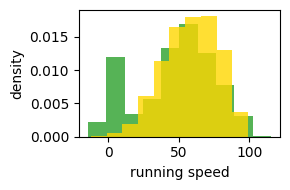

In [17]:
# running speed during go trials at all time stamps 

def flatten(l):
    # function to flatten a list of lists 
    return np.array([item for sublist in l for item in sublist])

engaged_speed = []
disengaged_speed =[]

engaged_time = []
disengaged_time =[]

for index, state in states.items():
    t_start = trial_metadata.iloc[index].start_time
    t_stop = trial_metadata.iloc[index].stop_time
    t = np.where((running_time >= t_start) & (running_time <= t_stop))[0]
    if not state:
        engaged_speed.append(running_speed[t])
        engaged_time.append(running_time[t])
    else:
        disengaged_speed.append(running_speed[t])
        disengaged_time.append(running_time[t])
        
fig,ax = plt.subplots(figsize = (3, 2)) 
plt.hist(flatten(engaged_speed), color = 'tab:green', density = True, alpha = 0.8);
plt.hist(flatten(disengaged_speed), color = 'gold', density = True, alpha = 0.8);
plt.ylabel('density')
plt.xlabel('running speed')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Mice seem to be stopping a lot more in the engaged state. To see why, we can look at the running speeds during engaged states. 
</div>

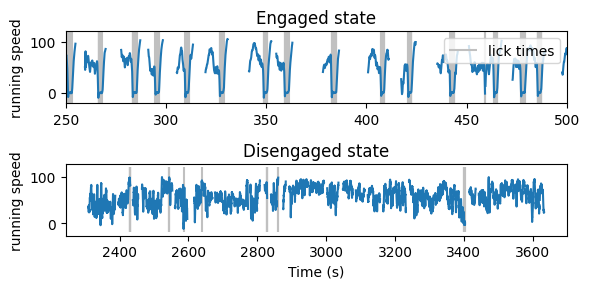

In [18]:
lick_times = trial_metadata[trial_metadata.go].lick_times
engaged_lick_times = lick_times[~states.values]
disengaged_lick_times = lick_times[states.values]

fig, ax = plt.subplots(2, 1, figsize = (6, 3))

ax[0].set_title('Engaged state')
for time, speed in zip(engaged_time, engaged_speed):
    ax[0].plot(time, speed, color = 'tab:blue')
ax[0].vlines(flatten(engaged_lick_times.values), ymax = 120, ymin = -20, color = 'silver', label = 'lick times')
ax[0].set_ylim(-20, 120)
ax[0].set_xlim(250,500)
ax[0].legend(loc = 'upper right')
ax[0].set_ylabel('running speed')

ax[1].set_title('Disengaged state')
for time, speed in zip(disengaged_time, disengaged_speed):
    ax[1].plot(time, speed, color = 'tab:blue')
ax[1].vlines(flatten(disengaged_lick_times.values), ymax = 120, ymin = -20, color = 'silver', label = 'lick times')
ax[1].set_xlabel('Time (s)')
ax[0].set_ylim(-20, 120)
# ax[1].set_xlim(3000,3250) # change limits for different mice
ax[1].set_ylabel('running speed')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> They seem to be doing so in order to lick the spout to recieve the water reward. This act of stopping seems to be externally driven. Is there a more internally driven behavioral metric we can look at? Pupil size/area is commonly used to measure arousal levels of mice. Let us see how this metric varies during the engaged and disengaged states. 
</div>

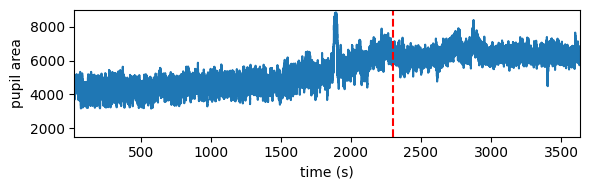

In [19]:
# pupil size

pupil_time = session.eye_tracking.timestamps
pupil_area = session.eye_tracking.pupil_area

fig,ax = plt.subplots(figsize = (6, 2))
plt.plot(pupil_time, pupil_area)
ax.set_xlim(start_time, stop_time)

for i in range(len(time_at_switch)):
    plt.plot(time_at_switch[i]*np.ones(5), np.linspace(1500, 9000, 5), color = 'r' , ls = '--')
ax.set_ylim(1500, 9000)
ax.set_xlabel('time (s)')
ax.set_ylabel('pupil area')
plt.tight_layout()

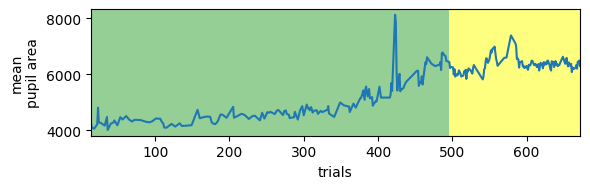

In [20]:
# meanpupil area in each trial

trial_start = trial_metadata.start_time[np.where(trial_metadata.go)[0]]
trial_stop = trial_metadata.stop_time[np.where(trial_metadata.go)[0]]

mean_pupil_area = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_time, pupil_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

fig,ax = plt.subplots(figsize = (6, 2))
plt.plot(go_trials, mean_pupil_area)

for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='yellow', alpha=0.5)

ax.set_xlabel('trials')
ax.set_ylabel('mean\npupil area')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Pupil size seems to be gradually increasing as the session ends. Could it be a good predictor of a state transition? 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> As we have seen until now, the mouse's behavior varies with changes in its internal state. However, we have only observed these states indirectly through a mouse's behavior.
Here, we inferred a state change into an "inattentive/disengaged" state since the mouse stopped licking in response to stimulus changes. 
The internal states we infer from behavior can offer clues for when we should look for changes in the underlying neural activity. Let us see how the neural responses to image changes differ between the two behavioral states we've inferred. 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> First, we have to access the unit data, pick an area of interest and filter out any bad units using the pre-determined quality control metrics (see Jupyter notebook for details). 
</div>

In [48]:
# filter out good units
probe_id = session.probes[session.probes.name == 'probeA'].index.values
unit_table = session.get_units(probe_id, amplitude_cutoff_maximum = 0.1, 
                               presence_ratio_minimum = 0.9, isi_violations_maximum = 0.5) # to do: this table does not include ccf location. 
unit_table = get_units_table().set_index('unit_id').loc[unit_table.index.values] 

# area of interest
area_of_interest = ['CA1'] # region in the hippocampus!
unit_nos = np.array([idx for idx, ccf in enumerate(unit_table.structure_acronym.values) if ccf in area_of_interest])

unit_ids = unit_table.index[unit_nos]
final_unit_table = unit_table.loc[good_unit_ids]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Now that we have information about our units, let us access their spike times. 
</div>

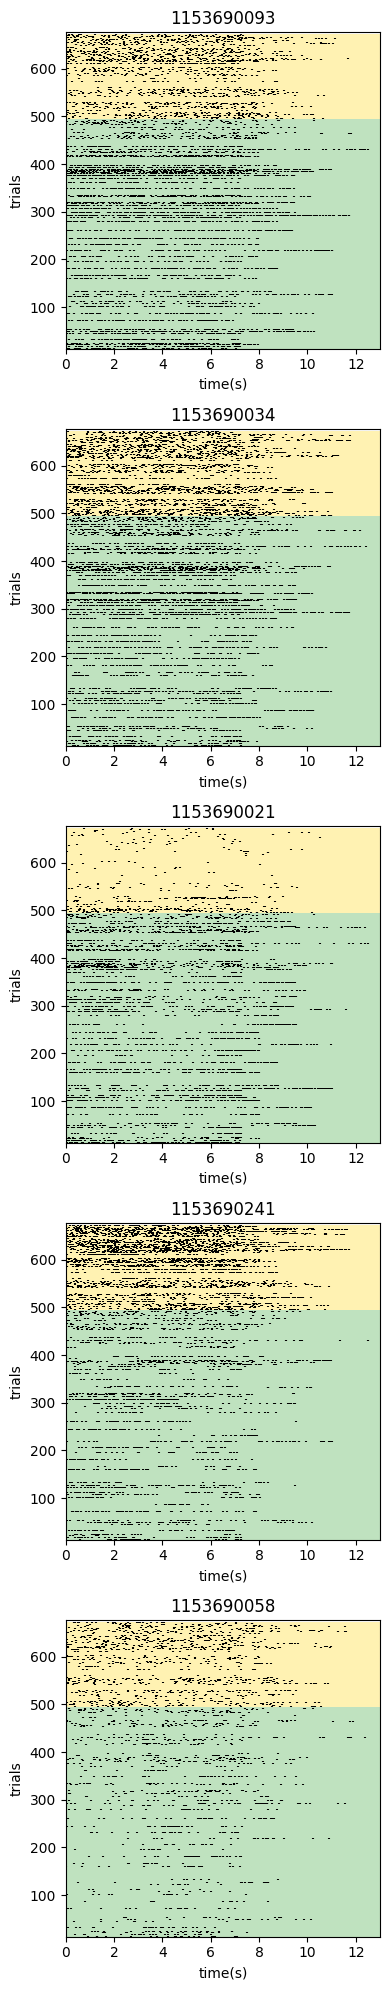

In [93]:
example_unit_ids = [1153690093, 1153690034, 1153690021, 1153690241, 1153690058]

start_times = trial_metadata[trial_metadata.go].start_time
stop_times = trial_metadata[trial_metadata.go].stop_time

fig, ax = plt.subplots(5,1, figsize = (4, 20))
for n, unit in enumerate(example_unit_ids):
    unit_data = session.spike_times[unit]
    spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
    firing_rate = [len(spikes)/(s2 - s1) for spikes, s1, s2 in zip(spike_times, start_times, stop_times)]
    
    ax[n].eventplot(spike_times, color = 'k', lineoffsets = go_trials);
    for i, trial in enumerate(switch_trials[:-1]):
        if not states.values[trial+1]: 
            ax[n].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.3)
        else:
            ax[n].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.3)
    ax[n].set_title(unit)    
    ax[n].set_ylim(go_trials[0], go_trials[-1]+4)
    ax[n].set_xlabel('time(s)')
    ax[n].set_xlim(0, 13)
    ax[n].set_ylabel('trials')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Here, we see a few different spiking responses to the change detection task in the hippocampus. In these example neurons, we see a difference in spiking activity when the mouse switches from the "engaged" to the "disengaged" state. To see these effects more clearly, we can plot the mean firing rates of each of the neurons.
</div>

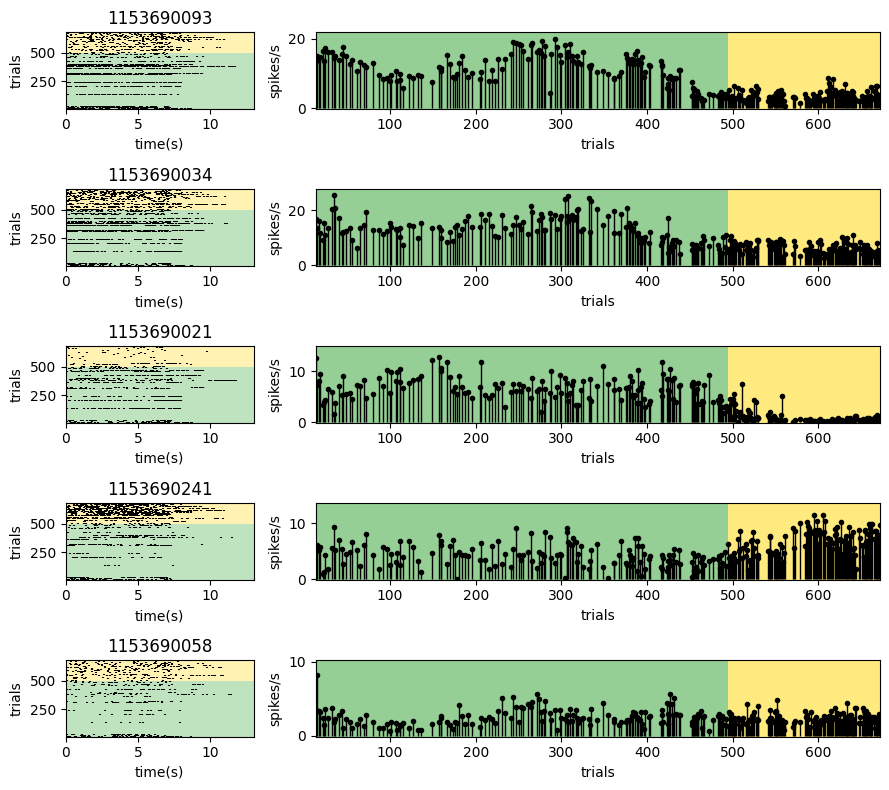

In [113]:
fig,ax = plt.subplots(5, 2, figsize = (9, 8), gridspec_kw={'width_ratios': [1, 3]}) 

example_unit_ids = [1153690093, 1153690034, 1153690021, 1153690241, 1153690058]
for n, unit in enumerate(example_unit_ids):
    unit_data = session.spike_times[unit]
    spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
    firing_rate = [len(spikes)/(s2 - s1) for spikes, s1, s2 in zip(spike_times, start_times, stop_times)]
    
    ax[n, 0].eventplot(spike_times, color = 'k', lineoffsets = go_trials);
    for i, trial in enumerate(switch_trials[:-1]):
        if not states.values[trial+1]: 
            ax[n, 0].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.3)
        else:
            ax[n, 0].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.3)
    ax[n, 0].set_title(unit)    
    ax[n, 0].set_ylim(go_trials[0], go_trials[-1]+4)
    ax[n, 0].set_xlabel('time(s)')
    ax[n, 0].set_xlim(0, 13)
    ax[n, 0].set_ylabel('trials')

    markerline, stemlines, baseline = ax[n, 1].stem(go_trials, firing_rate, linefmt='k', basefmt='none', markerfmt = 'ok')
    plt.setp(markerline, markersize=3)
    plt.setp(stemlines,linewidth = 1)
    ax[n, 1].set_xlim(go_trials[0], go_trials[-1])
    for i, trial in enumerate(switch_trials[:-1]):
        if not states.values[trial+1]: 
            ax[n, 1].axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
        else:
            ax[n, 1].axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5)
    ax[n, 1].set_ylim(-0.1, np.max(firing_rate)+2)
    ax[n, 1].set_xlabel('trials')
    ax[n, 1].set_ylabel('spikes/s')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We can see a decrease in activity of the neurons as the mouse transitions to a disengaged state. However, based on the structural, physiological and genetic attributes, different cell types can have significantly different responses. In this example set of neurons, we can also see neurons that increase their firing in the disengaged state or don't reflect any variations due to a state switch.  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> In this workshop, we analyzed a mouse's behavior as it performed a change detection task. We identified two behavioral states using a simple performance metric: the hit rate. We summarized its behavioral profile in each state and observed changes in neural activity associated with state transitions. 
    
<p> However, our definition of behavioral states uses a crude thresholding methodology based on a single variable. While informative, this definition is incomplete. Moreover, we identified other behavioral metrics relevant to state transitions, yet we did not incorporate this information to define the behavioral states. This additional information could help us refine our understanding of behavioral states, introducing multiple latent states that are difficult to observe by simple eyeballing. In the afternoon workshop, we will explore more sophisticated methods to define behavioral states that can incorporate multi-variate information about a mouse's behavioral profile. 

<p> In our current analyses, the threshold to define behavioral states "seemed" appropriate for the mouse we studied. However, the same thresholding techniques may not generalize across mice. Disengagement levels and their markers may vary across different mice. Mice may involve in different behaviors to remain engaged, and they may vary in their motivations and strategies. So, how can we systematically assess state changes across many mice? Let us tackle this question in Workshop 2. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Problem sets and project ideas </h2>
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.1: Plot the distribution of reaction times for go trials from one session</b>

<p> 1) get the <code>trials</code> dataframe from the session object. 
    
<p> 2) Filter the trials dataframe to get go trials only. 
    
<p> 3) Use the values of the <code>response_latency</code> column to plot a histogram of reaction times. 
    
<p> <code>response_latency</code> is the first lick time, in seconds, relative to the change time. 
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2: Determine behavioral states for each mouse by eyeballing the hit rate. Can you device a systematic way to quantify this threshold? </b>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3: How do running speed, pupil size and hit rate correlate for different mice? Do different transgenic mouse lines have different behavioral state statistics?  </b>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4: Do different mouse lines spend different amounts of time in “task engaged” vs “task disengaged” behavioral states?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5: Can we use regression to predict state transition? </b>

<p> 1) Construct a design matrix using behavior input covariates.  
    
<p> 2) Use a threshold to determine states using hit rate.

<p> 3) Set up a regression model and evaluate model performance on state prediction. 
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Solution Set </h3>
<p>  You will also need to provide a separate solution set for (some of) these notebooks, so that students can have a reference or self study guide.  In addition, save an html version of the solution set notebook so that there will be an unalterable version in case students play around with the solution notebook.  It will probably not be practical to have detailed solutions for every single problem, so be mindful of what problems should have detailed solutions and what problems would provide good examples.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> After Dinner Session</h2>
   
The last session, which will convene after dinner, serves a few purposes.
    
<ul>
<li> Answering any questions that students have.
<li> Demonstrating any solutions that might be useful for everyone to see or talk through.
<li> Providing examples of recent literature that uses the demonstrated methods.
<li> Outlining potential longer problems that could be the basis of projects
<li> Developing project ideas
</ul>
    
<p> We will coordinate these sessions across days in the larger groups, but put some thought into what makes sense for your day.
    
<!-- <p>The hard part of this section is the last two points.  Your group can decide in advance or on the day of the event whether certain solutions should be highlighted.  What you need to prepare are lists of more involved problems (e.g. these could be problems that you didn't include in the Problem Set above) and providing potential project ideas.  
    
<p> Construct a slide or slides of a few project ideas for your dataset and take a few minutes to talk through these ideas with the students at this session. -->
    
</div>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h1> A few more things </h1>
    
<p> Keep things as simple as possible!  If you don't need a module or method to illustrate the concepts you're aiming to teach, leave it out.  
<p> One note on simplicity:  be careful not to get students bogged down in complex visualizations where they spend all their time struggling with matplotlib or something.  
    
<p> Be VERY mindful of what might be distracting for a student in both cognitive and technical terms.  It's impossible to hold everyone's attention and harder for people to learn something if TAs have to run around fixing technical issues.
    
<p> If there is a method or tool that you *really* want to show students but isn't part of the main thrust of the notebook, please consider a problem for the Problem Set or an entry in our Jupyter Book.

    
<p> All of this material will be put into a github repo at <a href="https://github.com/AllenInstitute/swdb_2023">SWDB 2023 GitHub repo</a>, including this template (until the course starts).
    
<p> Please work on a fork on this repo for your group.
        
<p>  Please be aware that jupyter notebooks can be finicky with git.  We've had situations in the past where people have accidentally erased other people's work.  Please be mindful of your commits and backup your work just in case.  

</div>